# Test di Pearson

Il test di Pearson è un criterio di confronto (non parametrico )che ci consente di conoscere quale coppia di parametri $a$ e $b$ è quella che meglio descrive i dati a nostra disposizione.


Il test consiste nel ripetere questi cinque passaggi per ogni durata:
1. Suddividere in 5 parti uguali il campo di probabilità (quantili)
2. Derivare una suddivisione del dominio in 5 intervalli
3. Contare il numero di dati per ogni intervallo
4. Valutare la funzione:
\begin{equation}
X^2=\sum_i^5 \frac{N_i - 22\cdot(P[H<h_{6}]-P[H<h_5])^2}{22\cdot(P[H<h_{6}]-P[H<h_5])}
\end{equation}
5. Scegliere la coppia di parametri che minimizza il valore di $X^2$

Con:
- Numero di misurazioni totali: $n = 22$
- Numero di intervalli: $j=5$
- Numero di dati in ciascun i-esimo intervallo: $N_i$.


La curva migliore è quella che suddivide i dati negli intervalli, in un numero di elementi equivalente sul suo dominio.

La trattazione è svolta inizialmente con durate orarie e poi ripetuta con [durate sub-orarie](#p_sub).

In [1]:
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline 
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np

data = pd.read_csv('PluviometriaVE.txt')
map(datetime,data['anno'])
data=data.set_index('anno')

In [2]:
data

,1h,3h,6h,12h,24h
anno,,,,,
2000,36.2,36.2,62.0,73.2,93.2
2001,37.0,52.8,55.0,69.8,78.8
2002,41.8,55.4,58.2,59.0,60.0
2003,25.8,29.8,31.0,41.0,46.8
2004,21.2,28.0,39.0,45.6,61.6
2005,57.2,60.8,61.0,70.0,90.2
2006,36.0,50.4,57.4,93.6,109.2
2007,65.8,92.4,107.4,113.6,127.4
2008,47.2,49.4,59.6,89.8,102.2


In [3]:
from scipy.stats import norm
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
from pylab import plot,show,hist,figure,title

Dopo aver scaricato le librerie necessarie, andiamo a leggere i file di dati contenenti le coppie di parametri $a$ e $b$, calcolate in precedenza col metodo dei momenti, il metodo dei minimi quadrati e il metodo della massima verosimiglianza. Riportiamo tali risultati in modo che sia subito possibile fare un confronto tra i risultati:

Parametri ottenuti con il metodo dei momenti:

In [4]:
ab_m=pd.read_pickle("ab_m")
ab_m

,1h,3h,6h,12h,24h
a,31.831174,38.980308,45.614355,54.800484,64.499459
b,14.955350,19.358860,21.048080,21.119360,23.011086


Parametri ottenuti con il metodo dei minimi quadrati:

In [5]:
ab_mq=pd.read_pickle("ab_mq")
ab_mq

,1h,3h,6h,12h,24h
a,29.837739,36.017755,43.599738,51.548581,61.241032
b,15.969347,17.806991,16.402918,21.612033,24.902769


Parametri ottenuti con il metodo della massima verosimiglianza:

In [6]:
ab_mle=pd.read_pickle("ab_mle")
ab_mle

,1h,3h,6h,12h,24h
a,31.724736,39.407941,46.548023,55.070815,64.518328
b,14.864016,16.922256,17.541655,19.266584,22.197209


Per eseguire il test di Pearson, bisogna come prima operazione dividere in quantili il campo di probabilità (o dominio). Ci si aspetta che, in ogni $i$-esimo intervallo, ci siano $e=(l1h\cdot q)$ elementi mentre ce ne sono  in realtà $o=(l1h \cdot r)$.  

La formula dell'$X^2$ è allora:
\begin{equation}
X^2 = \frac{1}{e}\sum_{i=1}^5 (e - o)^2
\end{equation}
Dove:
- $e $ : valori attesi; 
- $o $ : valori osservati; 


Definisco una funzione che mi permette di ottenere i valori di $X^2$ relativi a ogni per ciascuna durata. Tale funzione deve tenere conto dei dati, del DataFrame che contiene i parametri, la colonna che ci interessa e il delta calcolato sulle ascisse (essendoci 5 intervalli, il numero di dati che dovrebbero esserci per ogni intervallo se fossero distribuiti omogeneamente e: $0.2$).

All'interno di tale funzione, sono svolte le seguenti operazioni:
1. Si considerano i dati relativi a una durata oraria con la variabile $dt$
2. Si valutano i dati a nostra disposizione per ogni durata con $lh$
3. Viene definita $rv$ come funzione di Gumbel, ma descritta attraverso i parametri di posizione (informazioni sulla moda) e di scala (legata alla deviazione standard).
4. Si valuta quanti elementi ci sono all'interno di ciascun intervallo utilizzando la funzione ECDF; 
5. Viene definita la variabile $r$ per costruire un vettore le cui componenti descrivono la percentuale di dati presenti prima di un certo valore (ogni componente del vettore corrisponde a un quantile)
6. A partire dalla frazione $r$, si riporta il numero cumulato di valori osservati prima di un certo valore (in corrispondenza quindi dei vari intervalli) all'interno della variabile $o0$.
7. Viene definito un vettore $o$ che riporta i valori osservati effettivamente all'interno di ogni intervallo, sottraendo a $o0$ un vettore equivalente ma preceduto da uno 0
8. Viene definita la variabile $e$ che ritorna i valori attesi in ogni intervallo se fossero distribuiti omogeneamente, dato il numero di intervalli (definito da *len(r)* )
9. Viene calcolato il valore di $X^2$ con la relazione descritta in precedenza.


In [7]:
def X2(data,abs_t,h,delta):
    
    # considero i dati relativi a una durata oraria
    dt=data[h].dropna()
    
    # numero dei dati presenti in dt 
    lh=len(dt)
        
    # Funzione di Gumbel descritta attraverso i parametri di posizione e di scala 
    rv=gumbel_r(loc=abs_t.at["a",h],scale=abs_t.at["b",h])
    
    # inversa alla curva di Gumbel calcolata in un certo livello di probabilità
    q=[delta*(i+1) for i in range(int(1/delta))]
        
    # percentuale di dati presenti all'interno di ciascun intervallo
    ecdf = ECDF(dt)
    r=ecdf(rv.ppf(q))
    
    # numero di valori cumulati prima di ogni intervallo 
    o0=lh*r
    
    # numero di valori osservati in ciascun intervallo
    o=o0-np.append([0],np.delete(o0,-1))
    
    # numero di valori attesi
    e=[delta*lh for i in range(len(r))]
    
    return ((o-e)**2/e).sum()  

Per ogni durata scegliamo il caso migliore, che abbiamo infatti ottenuto con interpolazioni diverse.
Così facendo possiamo selezionare i parametri da utilizzare nell'analisi finale scegliendo quindi quelli con $X^2$ più piccolo.

Per costruire un data frame coi parametri migliori introduco intanto un vettore $a$ su cui inserisco i valori appena trovati:

In [8]:
a=[]
for  h in data.columns:
    a=a+[[X2(data,ab_m,h,0.2),X2(data,ab_mq,h,0.2),X2(data,ab_mle,h,0.2)]]
   
Dati = pd.DataFrame(a,index=["1h","3h","6h","12h","24h"],columns=["M","Mq","MLE"])
Dati

,M,Mq,MLE
1h,0.727273,0.727273,0.272727
3h,4.818182,5.727273,3.000000
6h,2.545455,8.000000,1.181818
12h,2.090909,2.545455,2.545455
24h,2.090909,3.454545,2.090909


Dopo averi calcolato $X^2$ con per le varie durate, si può notare che: 
- per la durata di 1h, 3h e 6h i parametri migliori sono relativi al metodo della massima verosimiglianza; 
- per la durata di 12h i parametri migliori corrispondono al metodo dei momenti; 
- per la durata di 24h i parametri migliori corrispondono al metodo dei momenti e della massima verosimiglianza 

Una volta individuati i valori minori possiamo creare manualmente la variabile $best$, che contiene i migliori parametri per le varie durate:

In [9]:
DatiT = Dati.T
DatiT.min()

1h     0.272727
3h     3.000000
6h     1.181818
12h    2.090909
24h    2.090909
dtype: float64

In [10]:
best=pd.DataFrame([ab_mle["1h"],
                ab_mle["3h"],
                ab_mle["6h"],
                ab_m["12h"],
                ab_m["24h"]]).T
                  
best

,1h,3h,6h,12h,24h
a,31.724736,39.407941,46.548023,54.800484,64.499459
b,14.864016,16.922256,17.541655,21.119360,23.011086


In [11]:
#salvo in un file i risultati
best.to_pickle("best_param")

In [12]:
def gumbel(x,ab_d,col):
    return np.exp(-np.exp(-(x-ab_d[col]["a"])/ab_d[col]["b"]))
t_rain=np.linspace(data.min()[0],data.max()[4],100)

Si ripetono quindi i passaggi seguiti anche negli altri casi per disegnare le curve che interpolano meglio i dati.
Questa volta i dati si scelgono dal DataFrame $best$.

Costruisco DataFrame con i dati da plottare: come indice si hanno le precipitazioni (ordinate dal valore minimo al massimo in [mm]), mentre in colonna la relativa probabilità per ogni durata:

In [13]:
gb = pd.DataFrame()
for i in ["24h","12h","6h","3h","1h"]:
    gb.insert(0,i,gumbel(t_rain,ab_mq,i))
gb.index = t_rain
gb

,1h,3h,6h,12h,24h
12.000000,0.047091,0.021222,0.001043,0.001963,0.000729
13.424242,0.061118,0.028536,0.001847,0.002921,0.001090
14.848485,0.077578,0.037508,0.003117,0.004238,0.001592
16.272727,0.096488,0.048276,0.005037,0.006004,0.002278
17.696970,0.117794,0.060941,0.007822,0.008320,0.003194
...,...,...,...,...,...
147.303030,0.999361,0.998070,0.998206,0.988163,0.968935
148.727273,0.999416,0.998219,0.998355,0.988914,0.970636
150.151515,0.999466,0.998355,0.998492,0.989617,0.972245
151.575758,0.999511,0.998482,0.998617,0.990276,0.973768


Riusciamo infine a trovare il miglior risultato secondo il Test di Pearson:

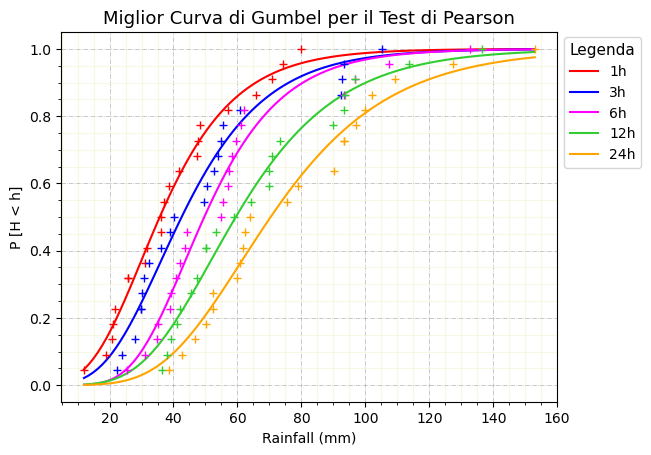

In [14]:
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.style.use('default')
ax=gb.plot(color=["red","blue","magenta","limegreen","orange"])
ecdf1h = ECDF(data["1h"])
ax.plot(data["1h"],ecdf1h(data["1h"]),'+',c="red", label="1h",markersize=6)
data3h=data["3h"]
ecdf3h = ECDF(data3h)
ax.plot(data3h,ecdf3h(data3h),"+",c="blue", label="3h",markersize=6)
data6h=data["6h"]
ecdf6h = ECDF(data6h)
ax.plot(data6h,ecdf6h(data6h),"+",c="magenta", label="6h",markersize=6)
data12h=data["12h"]
ecdf12h = ECDF(data12h)
ax.plot(data12h,ecdf12h(data12h),"+",c="limegreen", label="12h",markersize=6)
data24h=data["24h"]
ecdf24h = ECDF(data24h)
ax.plot(data24h,ecdf24h(data24h),"+",c="orange", label="24h",markersize=6)
legend = plt.legend(['1h','3h','6h','12h','24h'],loc='center left',  title = "Legenda", title_fontsize = 11, bbox_to_anchor=(1,0.81))
#plt.legend(['1h', '3h', '6h', '12h', '24h'], loc='center left',  title = "Durate Orarie", title_fontsize = 12, fontsize=11, bbox_to_anchor=(1,0.81))

ax.set_title('Miglior Curva di Gumbel per il Test di Pearson', fontsize=13)
ax.set_xlabel('Rainfall (mm)')
ax.set_ylabel('P [H < h]')
ax.set_aspect('auto')

#major grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=0.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=0.8)

Queste sono le curve che danno il miglior test di Pearson.

# Precipitazioni suborarie <a class="anchor" id="p_sub"></a>

Si ripete la trattazione per trovare la miglior coppia di parametri nel caso di precipitazioni suborarie:

In [31]:
dataM = pd.read_csv('PluviometriaMin.txt')
map(datetime,dataM['anno']) 
dataM=dataM.set_index('anno')
dataM

,15min,30min,45min
anno,,,
2000,20.8,29.6,32.6
2001,22.2,31.2,34.8
2002,26.2,36.6,41.0
2003,15.8,20.8,25.4
2004,13.6,18.6,19.2
2005,28.2,48.2,53.6
2006,18.0,24.4,30.8
2007,28.6,39.0,57.8
2008,18.6,34.4,43.8


In [32]:
ab_m=pd.read_pickle("ab_mMin")
ab_mq=pd.read_pickle("ab_mqMin")
ab_mle=pd.read_pickle("ab_mleMin")

def X2(data,abs_t,h,delta):
    dt=data[h].dropna()
    lh=len(dt)
    rv=gumbel_r(loc=abs_t.at["a",h],scale=abs_t.at["b",h])
    q=[delta*(i+1) for i in range(int(1/delta))]
    ecdf = ECDF(dt)
    r=ecdf(rv.ppf(q))
    o0=lh*r
    o=o0-np.append([0],np.delete(o0,-1))
    e=[delta*lh for i in range(len(r))]
    return ((o-e)**2/e).sum()  

a=[]
for  h in dataM.columns:
    a=a+[[X2(dataM,ab_m,h,0.2),X2(dataM,ab_mq,h,0.2),X2(dataM,ab_mle,h,0.2)]]
   
Dati = pd.DataFrame(a,index=["15min","30min","45min"],columns=["M","Mq","MLE"])
Dati

,M,Mq,MLE
15min,1.181818,0.727273,0.727273
30min,2.090909,0.727273,0.727273
45min,0.727273,1.636364,1.636364


In [26]:
DatiT = Dati.T
DatiT.min()

15min    0.727273
30min    0.727273
45min    0.727273
dtype: float64

In questo caso i dati migliori corrispondono a:
- Meotodo della massima verosimiglianza o dei minimi quadrati per durate di 15 min e 30 min
- Metodo dei momenti per durate di 45 min

In [28]:
best=pd.DataFrame([ab_mle["15min"],
                ab_mq["30min"],
                ab_m["45min"]]).T
best.to_pickle("best_p")                  
best

,15min,30min,45min
a,17.090649,24.351447,29.634609
b,6.053625,10.373396,12.634209


In [33]:
def gumbel(x,ab_d,col):
    return np.exp(-np.exp(-(x-ab_d[col]["a"])/ab_d[col]["b"]))
t_rain=np.linspace(dataM.min()[0],dataM.max()[2],100)

gb = pd.DataFrame()
for i in ["45min","30min","15min"]:
    gb.insert(0,i,gumbel(t_rain,ab_mq,i))
gb.index = t_rain
gb

,15min,30min,45min
7.200000,0.004479,0.005382,0.011472
7.806061,0.007634,0.007239,0.013861
8.412121,0.012346,0.009575,0.016614
9.018182,0.019042,0.012466,0.019762
9.624242,0.028141,0.015988,0.023334
...,...,...,...
64.775758,0.999718,0.979900,0.929321
65.381818,0.999746,0.981030,0.932210
65.987879,0.999771,0.982097,0.934985
66.593939,0.999794,0.983104,0.937650


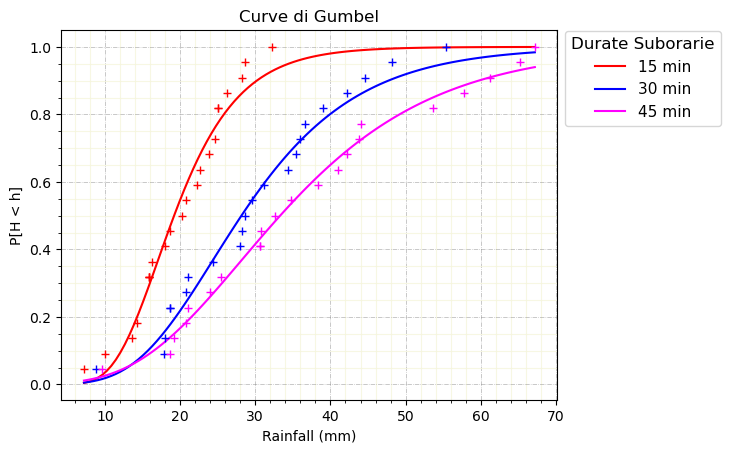

In [34]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 
plt.style.use('default')
ax=gb.plot(color=["red","blue","magenta"])
ecdf15 = ECDF(dataM["15min"])
ax.plot(dataM["15min"],ecdf15(dataM["15min"]),'+',c="red", label="15min",markersize=6) 
data30=dataM["30min"]
ecdf30 = ECDF(data30)
ax.plot(data30,ecdf30(data30),"+",c="blue", label="30min",markersize=6)
data45=dataM["45min"]
ecdf45 = ECDF(data45)
ax.plot(data45,ecdf45(data45),"+",c="magenta", label="45min",markersize=6)
ax.set_title('Curve di Gumbel')
ax.set_xlabel('Rainfall [mm]')
ax.set_ylabel('P[H < h]')
ax.set_aspect('auto')
plt.grid()
ax.set_title('Curve di Gumbel')
ax.set_xlabel('Rainfall (mm)')
ax.set_ylabel('P[H < h]')
ax.set_aspect('auto')
plt.legend(['15 min', '30 min', '45 min'], loc='center left',  title = "Durate Suborarie", title_fontsize = 12, fontsize=11, bbox_to_anchor=(1,0.87))
#major grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=0.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=0.8)
plt.show()